# Learned System Dynamics Model

The goal of the following experiements is to explore the feasibility of automatically discovering the underlying dynamics of a closed loop linear system by learning a mapping between controls applied to the system and the resulting changes in system state.

In [80]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

The first system under question will be a particle in a vaccum undergoing random (but known) accelerations via a control signal. The goal will be to recover the state-transition-matrix of the underlying ground truth dynamics by collecting operating data and optimizing parameters of a model to minimize the error between observed states, and network predicted states. For this scenario, the state of the system will be

In [81]:
def make_state(pos, vel):
    return np.concatenate([np.array(pos), np.array(vel)])

make_state([1, 2, 3], [4, 5, 6])

array([1, 2, 3, 4, 5, 6])

The ground truth STM that we are looking to recover will be

In [119]:
dt = 0.1
stm_gt = np.array([
    [1, 0, 0,dt, 0, 0, 0, 0, 0],
    [0, 1, 0, 0,dt, 0, 0, 0, 0],
    [0, 0, 1, 0, 0,dt, 0, 0, 0],
    [0, 0, 0, 1, 0, 0,dt, 0, 0],
    [0, 0, 0, 0, 1, 0, 0,dt, 0],
    [0, 0, 0, 0, 0, 1, 0, 0,dt],
])

First we will generate some samples of a random walk 

In [90]:

X = np.zeros((10000, 6), dtype=np.dtype("float32"))
U = np.zeros((10000, 3), dtype=np.dtype("float32"))

for i in range(0, X.shape[0] - 1):
    if i % 2 == 1:
        continue
    
    U[i] = np.random.normal(scale=0.1, size=3)
    X[i] = np.random.normal(scale=10, size=6)
    X[i+1] = stm_gt @ np.concatenate([X[i], U[i]])
    
XU = np.concatenate([X, U], axis=1)

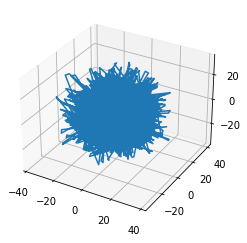

In [91]:
ax = plt.figure().add_subplot(projection='3d')
ax.plot(X[:,0], X[:,1], X[:,2])
plt.show()

Using cuda device
loss: 8.762771  [    0/20000]
loss: 7.689830  [ 1000/20000]
loss: 6.672772  [ 2000/20000]
loss: 5.542067  [ 3000/20000]
loss: 4.521553  [ 4000/20000]
loss: 3.365411  [ 5000/20000]
loss: 2.397649  [ 6000/20000]
loss: 1.404242  [ 7000/20000]
loss: 0.716546  [ 8000/20000]
loss: 0.321539  [ 9000/20000]
loss: 0.095517  [10000/20000]
loss: 0.028219  [11000/20000]
loss: 0.028821  [12000/20000]
loss: 0.027689  [13000/20000]
loss: 0.026878  [14000/20000]
loss: 0.027142  [15000/20000]
loss: 0.027708  [16000/20000]
loss: 0.027170  [17000/20000]
loss: 0.027563  [18000/20000]
loss: 0.027556  [19000/20000]


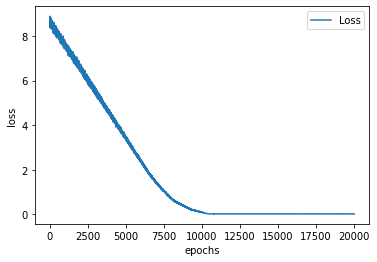

In [114]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.stm_stack = nn.Sequential(
            nn.Linear(9, 6, dtype=torch.float32, bias=False),
        )

    def forward(self, x):
#         print(x)
        x = self.flatten(x)
        outputs = self.stm_stack(x)
        return outputs

model = NeuralNetwork().to(device)


def train_loop(model, loss_fn, optimizer):
    epochs = 20000
    sample_indices = list(range(0, XU.shape[0] - 1, 2))
    losses = np.zeros(epochs)
    
    for epoch in range(epochs):
        batch_inds = np.random.choice(sample_indices, size=1000)
        X = torch.from_numpy(XU[batch_inds])
        Y = torch.from_numpy(XU[batch_inds+1,0:6])
        
        h = model(X.cuda())
        loss = loss_fn(h, Y.cuda())

        losses[epoch] = loss
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        if epoch % 1000 == 0:
            loss, current = loss.item(), epoch * len(X)
            print(f"loss: {loss:>7f}  [{epoch:>5d}/{epochs:>5d}]")

    ax = plt.figure().add_subplot()
    ax.plot(losses, label='Loss')
    ax.legend()
    ax.set_xlabel('epochs')
    ax.set_ylabel('loss')
    plt.show()

optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)
loss_fn = nn.L1Loss()

train_loop(model, loss_fn, optimizer)

In [115]:
stm_l = None
for name, param in model.named_parameters():
    if param.requires_grad:
        stm_l = param.detach().cpu().numpy()
        print(name, stm_l)

stm_stack.0.weight [[ 1.00047028e+00 -1.23128455e-04  5.88589719e-05  9.99867246e-02
   4.23702513e-05 -1.02404274e-05  1.02562830e-01  2.92257428e-01
  -2.93113083e-01]
 [-1.48575991e-05  1.00047588e+00 -9.51111215e-05  4.09311942e-05
   9.99674052e-02  1.85295139e-05  2.64887959e-01 -2.45015826e-02
   8.88006389e-02]
 [ 4.06964100e-05  3.68489564e-05  9.99773979e-01  7.08704329e-06
  -6.58972112e-06  1.00009255e-01  1.14488438e-01  8.12612996e-02
   8.38915631e-02]
 [-6.21220242e-05  5.08825451e-06  1.63785124e-04  1.00045586e+00
  -6.27124391e-05 -2.56318235e-05 -1.29459932e-01 -2.24084601e-01
  -1.32331014e-01]
 [-1.56208830e-06 -1.34899426e-04  1.91494299e-04 -9.65642016e-07
   1.00037646e+00 -9.21791525e-06 -3.01853657e-01  2.03584000e-01
  -2.59464949e-01]
 [ 7.79659531e-05  3.94177441e-05  8.88632785e-05  1.22449383e-05
   3.92108486e-05  9.99779463e-01  9.10290107e-02 -1.14366055e-01
  -2.67426819e-01]]


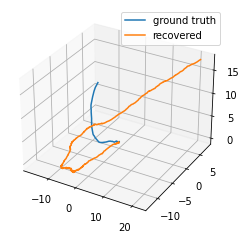

In [120]:
X_gt = np.zeros((1000, 6), dtype=np.dtype("float32"))
H = np.zeros((1000, 6), dtype=np.dtype("float32"))

for i in range(0, H.shape[0] - 1):
    u_i = np.random.normal(scale=0.1, size=3)
    X_gt[i+1] = stm_gt @ np.concatenate([X_gt[i], u_i])
    H[i+1] = stm_l @ np.concatenate([H[i], -u_i])
    
ax = plt.figure().add_subplot(projection='3d')
ax.plot(X_gt[:,0], X_gt[:,1], X_gt[:,2], label="ground truth")
ax.plot(H[:,0], H[:,1], H[:,2], label="recovered")
ax.legend()
plt.show()

In [121]:
stm_gt

array([[1. , 0. , 0. , 0.1, 0. , 0. , 0. , 0. , 0. ],
       [0. , 1. , 0. , 0. , 0.1, 0. , 0. , 0. , 0. ],
       [0. , 0. , 1. , 0. , 0. , 0.1, 0. , 0. , 0. ],
       [0. , 0. , 0. , 1. , 0. , 0. , 0.1, 0. , 0. ],
       [0. , 0. , 0. , 0. , 1. , 0. , 0. , 0.1, 0. ],
       [0. , 0. , 0. , 0. , 0. , 1. , 0. , 0. , 0.1]])

In [127]:
np.set_printoptions(suppress = True, precision=3)
stm_l

array([[ 1.   , -0.   ,  0.   ,  0.1  ,  0.   , -0.   ,  0.103,  0.292,
        -0.293],
       [-0.   ,  1.   , -0.   ,  0.   ,  0.1  ,  0.   ,  0.265, -0.025,
         0.089],
       [ 0.   ,  0.   ,  1.   ,  0.   , -0.   ,  0.1  ,  0.114,  0.081,
         0.084],
       [-0.   ,  0.   ,  0.   ,  1.   , -0.   , -0.   , -0.129, -0.224,
        -0.132],
       [-0.   , -0.   ,  0.   , -0.   ,  1.   , -0.   , -0.302,  0.204,
        -0.259],
       [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  1.   ,  0.091, -0.114,
        -0.267]], dtype=float32)